In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exercise 1

 - Import Barcelona_air_pollution data
 - Make a descriptive analysis to find the most interessting series to predict, for example you can answer your self if pollution levels are higher or lower during specific year seasons or parts of the day.
 - Train a LSTM NN and use the last 6 months history to validate (3 months) and test (3 months).
 - You can use weather data to improve your modelling and predictions.

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [3]:
air_pol = pd.read_csv('/content/drive/MyDrive/Barcelona_air_pollution.csv', sep = ';')
air_pol['date_hour0'] = air_pol['date'] + ' ' + air_pol['hour'].astype(str)
air_pol['date_hour'] = pd.to_datetime(air_pol['date_hour0'], format = '%d/%m/%Y %H')
air_pol.drop(['date','hour','date_hour0'], axis = 1, inplace = True)
air_pol.tail(5)

,lon,lat,CO,NO,NO2,O3,SO2,PM2_5,PM10,NH3,aqi,year,city,date_hour
17324,41.3888,2.159,216.96,0.0,0.07,40.05,0.05,2.71,5.42,0.37,1,2022,Barcelona,2022-12-31 20:00:00
17325,41.3888,2.159,216.96,0.0,0.07,38.98,0.05,3.10,6.23,0.40,1,2022,Barcelona,2022-12-31 21:00:00
17326,41.3888,2.159,213.62,0.0,0.07,41.13,0.09,4.61,9.95,0.41,1,2022,Barcelona,2022-12-31 22:00:00
17327,41.3888,2.159,210.29,0.0,0.06,45.06,0.11,5.32,12.26,0.36,1,2022,Barcelona,2022-12-31 23:00:00
17328,41.3888,2.159,213.62,0.0,0.06,48.64,0.09,4.33,10.00,0.30,1,2023,Barcelona,2023-01-01 00:00:00


In [4]:
weather = pd.read_csv('/content/drive/MyDrive/Barcelona_weather.csv', sep = ';')

weather['date'] = pd.to_datetime(weather['dt'],unit='s')
weather = weather[['date','temp','feels_like','pressure','humidity','wind_speed','dew_point', 'visibility','rain_1h']]
weather['rain_1h'].fillna(0, inplace = True)
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather = weather[weather['year'].isin([2018,2019,2020,2021,2022])]

def nans(df):
  for c in df.columns:
    df[c].bfill(inplace = True)
  return df

weather = nans(weather)

weather.drop_duplicates(inplace = True)
weather.reset_index(inplace = True)
weather.drop(['index'], axis = 1, inplace = True);
weather.head(3)

,date,temp,feels_like,pressure,humidity,wind_speed,dew_point,visibility,rain_1h,year,month
0,2018-01-01 00:00:00,14.63,13.61,1018,56,9.3,5.96,10000.0,0.0,2018,1
1,2018-01-01 01:00:00,13.31,12.05,1019,52,6.7,3.67,10000.0,0.0,2018,1
2,2018-01-01 02:00:00,12.35,11.10,1020,56,6.7,3.83,10000.0,0.0,2018,1


In [5]:
air_pol = air_pol.merge(weather, left_on = 'date_hour', right_on = 'date', how = 'left')
air_pol = air_pol.fillna(air_pol.mean())
air_pol.columns

Index(['lon', 'lat', 'CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3',
       'aqi', 'year_x', 'city', 'date_hour', 'date', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'dew_point', 'visibility',
       'rain_1h', 'year_y', 'month'],
      dtype='object')

<Figure size 1200x700 with 0 Axes>

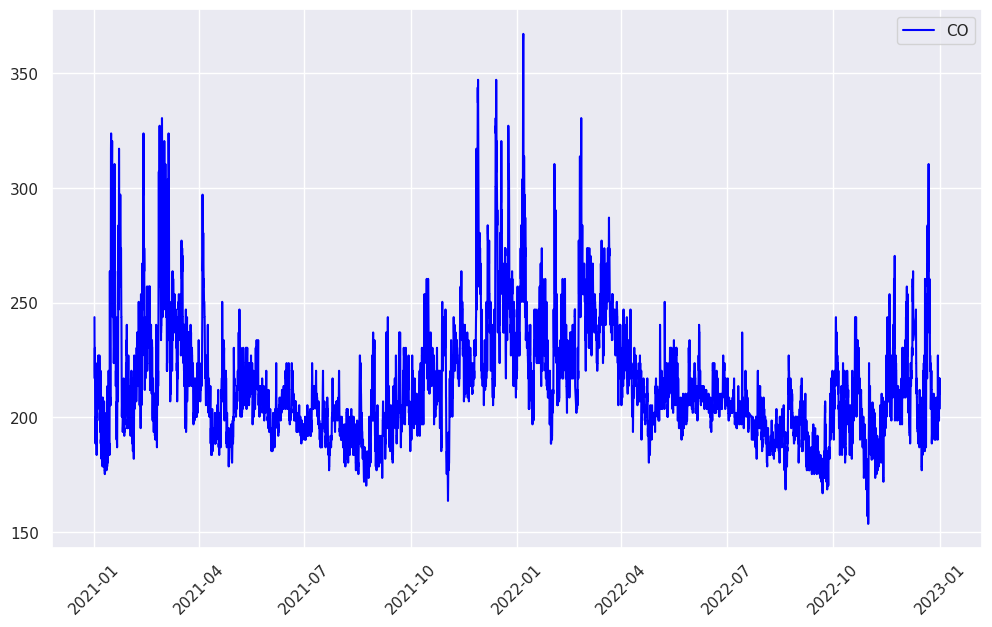

In [6]:
plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))
# ax2 = ax.twinx()

ax.plot(air_pol['date_hour'], air_pol['CO'], color = 'blue', label = 'CO')
plt.legend()
plt.xticks(rotation=45);

<Figure size 1200x700 with 0 Axes>

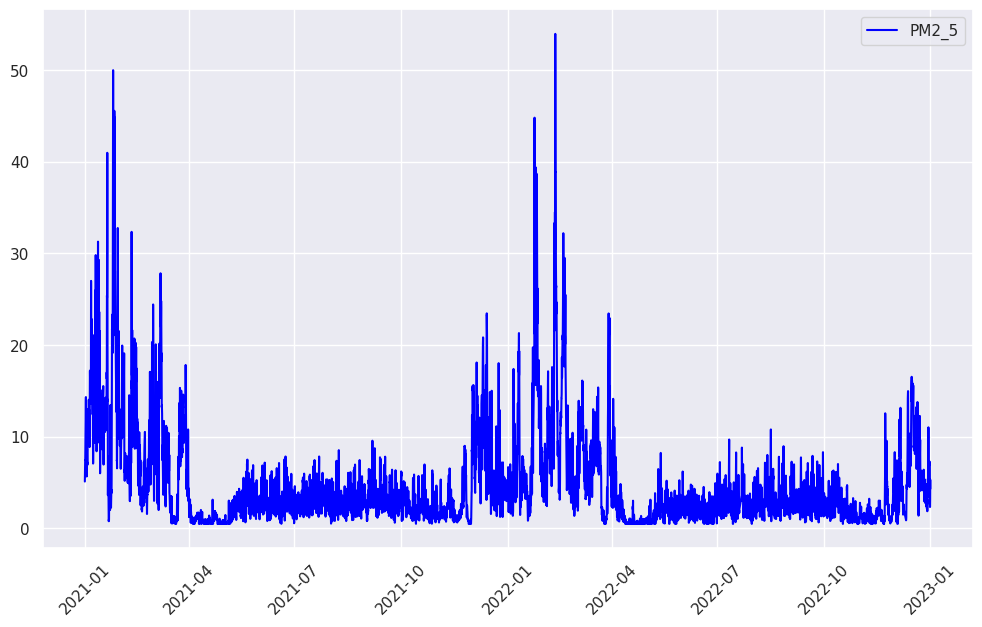

In [7]:
plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))
# ax2 = ax.twinx()

ax.plot(air_pol['date_hour'], air_pol['PM2_5'], color = 'blue', label = 'PM2_5')
plt.legend()
plt.xticks(rotation=45);

In [14]:
air_plot_train = air_pol[air_pol['date_hour']<='2022-06-30 23:00:0']
air_plot_val = air_pol[air_pol['date_hour'].between('2022-06-30 23:00:0','2022-09-30 23:00:0')]
air_plot_test = air_pol[air_pol['date_hour']>'2022-09-30 23:00:0']

air_plot_train.drop(['lon','lat','city','aqi','year_x','year_y', 'date', 'rain_1h', 'visibility', 'month'], axis = 1, inplace = True)
air_plot_val.drop(['lon','lat','city','aqi','year_x','year_y', 'date', 'rain_1h', 'visibility', 'month'], axis = 1, inplace = True)
air_plot_test.drop(['lon','lat','city','aqi','year_x','year_y', 'date', 'rain_1h', 'visibility', 'month'], axis = 1, inplace = True)

air_plot_train.columns = ['CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3','date', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'dew_point']
air_plot_val.columns = ['CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3','date', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'dew_point']
air_plot_test.columns = ['CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3','date', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'dew_point']

print(air_plot_train.head())

air_plot_train.drop(['date'], axis = 1, inplace = True)
air_plot_test.drop(['date'], axis = 1, inplace = True)
air_plot_val.drop(['date'], axis = 1, inplace = True)

X_train=air_plot_train
X_test=air_plot_test
X_val=air_plot_val

print(X_train.head())

scaler = StandardScaler()
sc = scaler.fit(X_train)

train_sc = sc.transform(X_train)
X_train_sc = pd.DataFrame(train_sc)
X_train_sc.columns = X_train.columns

val_sc = sc.transform(X_val)
X_val_sc = pd.DataFrame(val_sc)
X_val_sc.columns = X_val.columns

test_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(test_sc)
X_test_sc.columns = X_test.columns

y_train=X_train_sc[['CO']]
y_val=X_val_sc[['CO']]
y_test=X_test_sc[['CO']]

print(X_train_sc.head())
print(y_train)
print(X_train_sc.shape, y_train.shape)
print(X_test_sc.shape, y_test.shape)
print(X_val_sc.shape, y_val.shape)

def create_dataset(X, y, time_steps):
    Xs, ys = [], []

    for i in range(len(X) - time_steps):
      v = X.iloc[i:(i + time_steps)].values
      Xs.append(v)
      ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)

time_steps = 24

# reshape to [samples, time_steps, n_features]

X_train_shape, y_train_shape = create_dataset(X_train_sc, y_train, time_steps)
X_test_shape, y_test_shape = create_dataset(X_test_sc, y_test, time_steps)
X_val_shape, y_val_shape = create_dataset(X_val_sc, y_val, time_steps)

print(X_train_shape.shape, y_train_shape.shape)
print(X_test_shape.shape, y_test_shape.shape)


       CO   NO   NO2     O3   SO2  PM2_5   PM10   NH3                date  \
0  243.66  0.0  0.07  41.84  0.07   5.12  11.97  0.41 2021-01-01 00:00:00   
1  233.65  0.0  0.08  44.35  0.07   5.52  14.40  0.38 2021-01-01 01:00:00   
2  226.97  0.0  0.08  46.49  0.06   5.83  16.02  0.34 2021-01-01 02:00:00   
3  223.64  0.0  0.08  46.49  0.06   6.08  16.92  0.30 2021-01-01 03:00:00   
4  220.30  0.0  0.09  46.49  0.06   6.44  17.89  0.26 2021-01-01 04:00:00   

   temp  feels_like  pressure  humidity  wind_speed  dew_point  
0  9.11        8.43    1007.0      71.0         1.7       4.14  
1  8.46        7.31    1006.0      73.0         2.1       3.91  
2  8.14        6.94    1006.0      75.0         2.1       3.98  
3  6.98        4.51    1006.0      79.0         3.6       3.59  
4  6.89        4.40    1006.0      80.0         3.6       3.68  
       CO   NO   NO2     O3   SO2  PM2_5   PM10   NH3  temp  feels_like  \
0  243.66  0.0  0.07  41.84  0.07   5.12  11.97  0.41  9.11        8.43 

In [34]:
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Embedding

model = Sequential()
model.add(LSTM(64,return_sequences=True, input_shape = (X_train_shape.shape[1], X_train_shape.shape[2])))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, kernel_initializer='normal'))

model.compile(optimizer='adam', loss='mae', metrics=['mse'])
history = model.fit(X_train_shape, y_train_shape, epochs=16, batch_size=32, validation_data=(X_val_shape,y_val_shape))

Epoch 1/16
407/407 [==============================] - 9s 12ms/step - loss: 0.2842 - mse: 0.1919 - val_loss: 0.1036 - val_mse: 0.0188
Epoch 2/16
407/407 [==============================] - 4s 11ms/step - loss: 0.1093 - mse: 0.0254 - val_loss: 0.0817 - val_mse: 0.0102
Epoch 3/16
407/407 [==============================] - 6s 15ms/step - loss: 0.0897 - mse: 0.0173 - val_loss: 0.0640 - val_mse: 0.0069
Epoch 4/16
407/407 [==============================] - 4s 9ms/step - loss: 0.0867 - mse: 0.0157 - val_loss: 0.0514 - val_mse: 0.0049
Epoch 5/16
407/407 [==============================] - 4s 9ms/step - loss: 0.0830 - mse: 0.0150 - val_loss: 0.0685 - val_mse: 0.0075
Epoch 6/16
407/407 [==============================] - 7s 16ms/step - loss: 0.0840 - mse: 0.0151 - val_loss: 0.0585 - val_mse: 0.0060
Epoch 7/16
407/407 [==============================] - 4s 9ms/step - loss: 0.0817 - mse: 0.0146 - val_loss: 0.0594 - val_mse: 0.0061
Epoch 8/16
407/407 [==============================] - 3s 8ms/step - loss

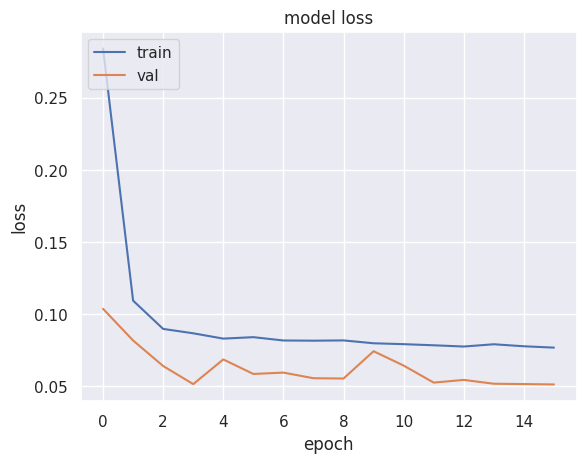

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
model.evaluate(X_test_shape, y_test_shape)

67/67 [==============================] - 0s 5ms/step - loss: 0.0847 - mse: 0.0148


[0.08473549783229828, 0.014805291779339314]

## Validation plots

67/67 [==============================] - 1s 4ms/step


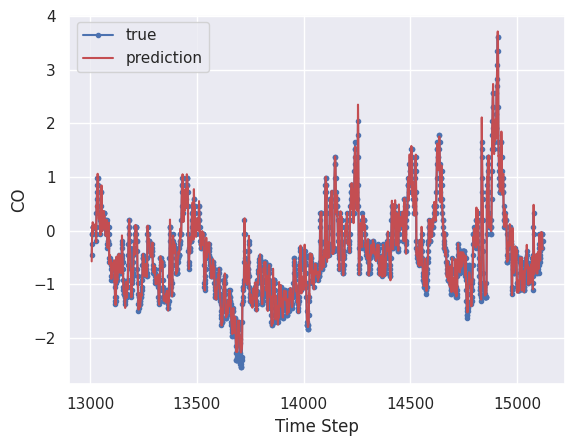

In [37]:
ypred_shape=model.predict(X_test_shape)

# plt.plot(np.arange(0, len(y_CO_train_shape)), y_CO_train_shape.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train_shape), len(y_train_shape) + len(y_test_shape)), y_test_shape, marker='.', label="true")
plt.plot(np.arange(len(y_train_shape), len(y_train_shape) + len(y_test_shape)), ypred_shape, 'r', label="prediction")
plt.ylabel('CO')
plt.xlabel('Time Step')
plt.legend()
plt.show();
